In [2]:
# 序列数据、标签的加载
import os
from PIL import Image
import torch
from torchvision import transforms

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.manual_seed(42)

# 若需更换face和eye，需改图片size
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = './dataset/UADFV/eye'

sequences = []
labels = []

for label, class_name in enumerate(['real', 'fake']):
    label_dir = os.path.join(data_dir, class_name)

    for sequence_idx in range(49):
        if sequence_idx == 5 or sequence_idx == 33 or sequence_idx == 43:
            continue

        sequence = []
        for image_idx in range(20):
            image_path = os.path.join(label_dir, f'{sequence_idx}_{image_idx}.png')
            image = Image.open(image_path).convert("RGB")
            if transform:
                image = transform(image)
            sequence.append(image)

        sequences.append(torch.stack(sequence))
        labels.append(label)

sequences = torch.stack(sequences)
labels = torch.tensor(labels)
print(sequences.shape)
print(labels.shape)

torch.Size([92, 20, 3, 128, 128])
torch.Size([92])


In [3]:
# sequence
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import numpy as np

dataset_size = sequences.size(0)
indices = list(range(dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
print(indices[:10])

sequences = sequences[indices]
labels = labels[indices]

# split1 = int(np.floor(0.6 * dataset_size))
# split2 = int(np.floor(0.8 * dataset_size))
# train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]

split = int(np.floor(0.8 * dataset_size))
test_size = dataset_size - split
# m = 1
# n = 2
# indices_left, test_indices, indices_right = indices[:(test_size * m)], indices[(test_size * m):(test_size * n)], indices[(test_size * n):]
# indices_left.extend(indices_right)
# train_indices = indices_left

# train_indices, test_indices = indices[:split], indices[split:]
test_indices, train_indices = indices[:test_size], indices[test_size:]

dataset = TensorDataset(sequences, labels)

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

seq_train_loader = DataLoader(dataset, batch_size=1, sampler=train_sampler)
seq_test_loader = DataLoader(dataset, batch_size=1, sampler=test_sampler)

print("Training set length:", len(train_indices))
print("Test set length:", len(test_indices))

[40, 22, 55, 72, 0, 26, 39, 67, 10, 44]
Training set length: 73
Test set length: 19


In [4]:
# image
extend_labels = []
images = []

for i in range(sequences.size(0)):
    for j in range(20):
        images.append(sequences[i][j])
        extend_labels.append(labels[i])

images = torch.stack(images)
img_labels = torch.tensor(extend_labels)

img_dataset_size = images.size(0)
img_indices = list(range(img_dataset_size))

# img_split1 = 10 * split1
# img_split2 = 10 * split2
# img_train_indices, img_val_indices, img_test_indices = img_indices[:img_split1], img_indices[img_split1:img_split2], img_indices[img_split2:]

img_split = 20 * split
img_test_size = img_dataset_size - img_split

# indices_left, img_test_indices, indices_right = img_indices[:(img_test_size * m)], img_indices[(img_test_size * m):(img_test_size * n)], img_indices[(img_test_size * n):]
# indices_left.extend(indices_right)
# img_train_indices = indices_left

# img_train_indices, img_test_indices = img_indices[:img_split], img_indices[img_split:]
img_test_indices, img_train_indices = img_indices[:img_test_size], img_indices[img_test_size:]

img_dataset = TensorDataset(images, img_labels)

img_train_sampler = SubsetRandomSampler(img_train_indices)
img_test_sampler = SubsetRandomSampler(img_test_indices)

img_train_loader = DataLoader(img_dataset, batch_size=32, sampler=img_train_sampler)
img_test_loader = DataLoader(img_dataset, batch_size=32, sampler=img_test_sampler)

print("Training set length:", len(img_train_indices))
print("Test set length:", len(img_test_indices))

Training set length: 1460
Test set length: 380


In [5]:
# 检查标签是否正常
all_labels = []
for data in seq_train_loader:
    inputs, label = data
    all_labels.extend(label.tolist())
all_labels = torch.tensor(all_labels)
print("Total number of labels:", len(all_labels))
num_positive_samples = (all_labels == 1).sum().item()
num_negative_samples = (all_labels == 0).sum().item()
print(f"Number of positive samples: {num_positive_samples}")
print(f"Number of negative samples: {num_negative_samples}")

Total number of labels: 73
Number of positive samples: 36
Number of negative samples: 37


In [6]:
from models import CustomVGG

img_model = CustomVGG().to(device)

In [7]:
# 网络结构
from models import LRCN
# from models import LRCN

seq_model = LRCN(8192, 1024, 1, 2).to(device) # 8192(eye) 25088(face)
# seq_model = LRCN().to(device)
# print(seq_model)

In [5]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq_model.parameters(), lr=0.001)
# optimizer = optim.SGD(seq_model.parameters(), lr=0.01, momentum=0.9)
# torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 设置 clipnorm
# torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)  # 设置 clipvalue

num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(seq_train_loader, 0):
        inputs, label = data
        inputs, label = inputs.to(device), label.to(device)

        seq_model.train()

        optimizer.zero_grad()

        # 前向传播
        outputs = seq_model(inputs)
        loss = criterion(outputs, label)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    loss = running_loss / len(seq_train_loader)
    accuracy = 100 * correct / total
    print('Epoch %d, loss: %.3f, accuracy: %.2f %%' % (epoch + 1, loss, accuracy))
    
    # 在每个 epoch 结束后进行模型评估
    # seq_model.eval()  # 将模型设置为评估模式，关闭 Dropout 和 BatchNormalization
    # val_correct = 0
    # val_total = 0
    # val_running_loss = 0.0
    # all_labels = []
    # all_predictions = []
    # with torch.no_grad():  # 在验证阶段不需要计算梯度
    #     for val_data in seq_val_loader:
    #         val_inputs, val_labels = val_data
    #         val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

    #         val_outputs = seq_model(val_inputs)
    #         val_loss = criterion(val_outputs, val_labels)
    #         # val_loss = F.cross_entropy(val_outputs, val_labels)
    #         val_running_loss += val_loss.item()

    #         _, val_predicted = torch.max(val_outputs.data, 1)
    #         val_total += val_labels.size(0)
    #         val_correct += (val_predicted == val_labels).sum().item()

    # val_accuracy = 100 * val_correct / val_total
    # avg_val_loss = val_running_loss / len(seq_val_loader)

    # print('Epoch %d, loss: %.3f, accuracy: %.2f %%. Validation, loss: %.3f, accuracy: %.2f %%' %
    #     (epoch + 1, loss, accuracy, avg_val_loss, val_accuracy))
    
    # if epoch == 0:
    #     best_val_accuracy = val_accuracy
    # # 保存最佳模型
    # if val_accuracy >= best_val_accuracy:
    #     best_val_accuracy = val_accuracy
    #     best_model_weights = model.state_dict()

Epoch 1, loss: 0.778, accuracy: 76.71 %
Epoch 2, loss: 0.108, accuracy: 97.26 %
Epoch 3, loss: 0.089, accuracy: 95.89 %
Epoch 4, loss: 0.049, accuracy: 95.89 %
Epoch 5, loss: 0.015, accuracy: 100.00 %
Epoch 6, loss: 0.058, accuracy: 98.63 %
Epoch 7, loss: 0.013, accuracy: 100.00 %
Epoch 8, loss: 0.009, accuracy: 100.00 %
Epoch 9, loss: 0.014, accuracy: 100.00 %
Epoch 10, loss: 0.010, accuracy: 100.00 %


In [6]:
# torch.save(seq_model, './model/UADFV/new/lrcn_eye_model_5.pth')

In [8]:
# CNN测试
from sklearn.metrics import roc_auc_score
img_model = torch.load('./model/UADFV/cnn_eye_model_2.pth')
correct = 0
total = 0
cnn_labels = []
cnn_predictions = []

with torch.no_grad():
    img_model.eval()
    for inputs, label in img_test_loader:
        inputs, label = inputs.to(device), label.to(device)
        outputs = img_model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        predictions = torch.sigmoid(outputs[:, 1])
        cnn_labels.extend(label.cpu().numpy())
        cnn_predictions.extend(predictions.cpu().detach().numpy())

cnn_test_accuracy = 100 * correct / total
auc = roc_auc_score(cnn_labels, cnn_predictions)
print("Test Accuracy: %.2f %%, AUC: %.4f" % (cnn_test_accuracy, auc))

Test Accuracy: 92.63 %, AUC: 0.9736


In [9]:
# LRCN测试
from sklearn.metrics import roc_auc_score
seq_model = torch.load('./model/UADFV/lrcn_eye_model_2_new.pth')
correct = 0
total = 0
lrcn_labels = []
lrcn_predictions = []
with torch.no_grad():
    seq_model.eval()
    for inputs, label in seq_test_loader:
        inputs, label = inputs.to(device), label.to(device)
        outputs = seq_model(inputs)

        _, predicted = torch.max(outputs, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        predictions = torch.sigmoid(outputs[:, 1])
        lrcn_labels.extend(label.cpu().numpy())
        lrcn_predictions.extend(predictions.cpu().detach().numpy())

lrcn_test_accuracy = 100 * correct / total
auc = roc_auc_score(lrcn_labels, lrcn_predictions)
print("Test Accuracy: %.2f %%, AUC: %.4f" % (lrcn_test_accuracy, auc))

Test Accuracy: 89.47 %, AUC: 1.0000


In [10]:
# Two stream(average)
# img_model = torch.load('./model/UADFV/cnn_eye_model_2.pth')
correct = 0
two_avg_labels = []
two_avg_predictions = []
with torch.no_grad():
    seq_model.eval()
    img_model.eval()
    for data in seq_test_loader:
        input, label = data
        input, label = input.to(device), label.to(device)
        img_output = []
        seq_output = seq_model(input)
        for t in range(20):
            img_output = img_model(input[:, t, :, :, :])

            img_output += seq_output

            _, predicted = torch.max(img_output, 1)
            correct += (predicted == label).sum().item()

            predictions = torch.sigmoid(img_output[:, 1])
            two_avg_labels.extend(label.cpu().numpy())
            two_avg_predictions.extend(predictions.cpu().detach().numpy())

total = 20 * len(seq_test_loader)
two_avg_test_accuracy = 100 * correct / total
auc = roc_auc_score(two_avg_labels, two_avg_predictions)
print("Test Accuracy: %.2f %%, AUC: %.4f" % (two_avg_test_accuracy, auc))

Test Accuracy: 99.47 %, AUC: 1.0000


In [10]:
# Two stream(SVM)
# img_model = torch.load('./model/DeepfakeTIMIT/HQ/cnn_eye_model_5.pth')
img_train_output = []
img_train_label = []

with torch.no_grad():
    seq_model.eval()
    img_model.eval()
    for data in seq_train_loader:
        input, label = data
        input, label = input.to(device), label.to(device)
        output = []
        seq_output = seq_model(input)
        for t in range(20):
            output = img_model(input[:, t, :, :, :])

            output += seq_output
            
            # output = torch.cat((output, seq_output), dim=1)
            # output = torch.sigmoid(output)
            img_train_output.append(output)
            img_train_label.append(label)
print(len(img_train_output))

1460


In [28]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV

img_train_output_tensor = torch.stack(img_train_output)
img_train_label_tensor = torch.cat(img_train_label)

img_train_output_flattened = img_train_output_tensor.view(img_train_output_tensor.size(0), -1).cpu().numpy()
img_train_label_flattened = img_train_label_tensor.cpu().numpy()

# svm_classifier = svm.SVC(kernel='linear', probability=True)

# # 使用径向基函数核（RBF kernel）并设置惩罚参数C和gamma
# svm_classifier = svm.SVC(kernel='rbf', C=0.1, gamma='scale', probability=True) # 0.1

# 使用多项式核函数并设置阶数和惩罚参数C
# svm_classifier = svm.SVC(kernel='poly', degree=3, C=0.1, probability=True)

# 使用Sigmoid核函数并设置coef0和惩罚参数C
svm_classifier = svm.SVC(kernel='sigmoid', coef0=0.0, C=0.1, probability=True) # 0.2

calibrated_svm = CalibratedClassifierCV(svm_classifier)

calibrated_svm.fit(img_train_output_flattened, img_train_label_flattened)

y_train_pred = calibrated_svm.predict(img_train_output_flattened)

accuracy = accuracy_score(img_train_label_flattened, y_train_pred)
print(f"Accuracy of SVM classifier on train dataset: {accuracy:.4f}")

Accuracy of SVM classifier on train dataset: 1.0000


In [29]:
import joblib
# 保存训练好的 SVM 模型到文件
model_filename = './model/UADFV/svm/fusion_eye_2_s.pkl'
joblib.dump(calibrated_svm, model_filename)

['./model/UADFV/svm/fusion_eye_2_s.pkl']

In [11]:
test_output = []
test_label = []

with torch.no_grad():
    seq_model.eval()
    img_model.eval()
    for data in seq_test_loader:
        input, label = data
        input, label = input.to(device), label.to(device)
        output = []
        seq_output = seq_model(input)
        for t in range(20):
            output = img_model(input[:, t, :, :, :])

            output += seq_output
            
            # output = torch.cat((output, seq_output), dim=1)
            # output = torch.sigmoid(output)
            test_output.append(output)
            test_label.append(label)
print(len(test_output))

380


In [12]:
# 加载保存的 SVM 模型
import joblib
from sklearn.metrics import accuracy_score
model_filename = './model/UADFV/svm/fusion_eye_2_s.pkl'
loaded_model = joblib.load(model_filename)

img_output_tensor = torch.stack(test_output)
img_label_tensor = torch.cat(test_label)

img_output_flattened = img_output_tensor.view(img_output_tensor.size(0), -1).cpu().numpy()
img_label_flattened = img_label_tensor.cpu().numpy()

y_pred = loaded_model.predict(img_output_flattened)
prob_scores = loaded_model.predict_proba(img_output_flattened)

accuracy = accuracy_score(img_label_flattened, y_pred)
print(f"Accuracy of SVM classifier on test dataset: {accuracy:.4f}")

Accuracy of SVM classifier on test dataset: 0.9974


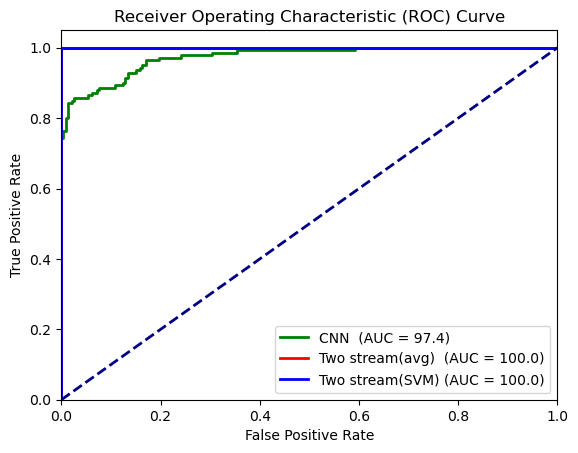

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(cnn_labels, cnn_predictions)
# lrcn_fpr, lrcn_tpr, lrcn_thresholds = roc_curve(lrcn_labels, lrcn_predictions)
# seq_fpr, seq_tpr, seq_thresholds = roc_curve(seq_labels, seq_predictions)
two_avg_fpr, two_avg_tpr, two_avg_thresholds = roc_curve(two_avg_labels, two_avg_predictions)
svm_fpr, svm_tpr, svm_thresholds = roc_curve(img_label_flattened, prob_scores[:, 1])

# 计算AUC值
cnn_roc_auc = auc(cnn_fpr, cnn_tpr)
# lrcn_roc_auc = auc(lrcn_fpr, lrcn_tpr)
# seq_roc_auc = auc(seq_fpr, seq_tpr)
two_avg_roc_auc = auc(two_avg_fpr, two_avg_tpr)
svm_roc_auc = auc(svm_fpr, svm_tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(cnn_fpr, cnn_tpr, color='green', lw=2, label='CNN  (AUC = %0.1f)' % (100 * cnn_roc_auc))
# plt.plot(lrcn_fpr, lrcn_tpr, color='darkorange', lw=2, label='LRCN (AUC = %0.1f)' % (100 * lrcn_roc_auc))# darkorange
# plt.plot(seq_fpr, seq_tpr, color='red', lw=2, label='Two stream(avg) (AUC = %0.1f)' % (100 * seq_roc_auc))
plt.plot(two_avg_fpr, two_avg_tpr, color='red', lw=2, label='Two stream(avg)  (AUC = %0.1f)' % (100 * two_avg_roc_auc))
plt.plot(svm_fpr, svm_tpr, color='blue', lw=2, label='Two stream(SVM) (AUC = %0.1f)' % (100 * svm_roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [3]:
# data = [100, 92.63, 91.32, 96.32, 94.74]
# data = [99.47, 100, 100, 100, 100]
# data = [63.16, 57.89, 52.63, 57.89, 52.63]
# data = [91.05, 93.16, 89.74, 94.74, 95]
data = [99.21, 99.74, 100, 100, 100]

total = 0
for i in range(len(data)):
    total += data[i]

average = total / 5
print(average)

99.78999999999999
